# Patches with Simulation Data

## Import Packages

In [37]:
from ladder.scripts import InterpretableWorkflow
import scanpy as sc
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from umap import UMAP

## Helper Functions

In [44]:
def force_aspect(ax,aspect=1):
    # helper function for plotting
    # based on Patches tutorial docs
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

def create_umap_df(workflow, model):
    # function to create a dataframe with all the reductions needed for plotting
    # based on Patches tutorial docs

    # UMAP reducers
    reducer_base = UMAP(n_neighbors=50, min_dist=0.1, metric="correlation", verbose=False, random_state=42)
    reducer = UMAP(n_neighbors=50, min_dist=0.1, metric="correlation", verbose=False, random_state=42)

    match model:
        case "Patches":
            # all data reductions needed for the plots
            base_umap = reducer_base.fit_transform(np.array(workflow.anndata.X))
            z_umap = reducer.fit_transform(workflow.anndata.obsm['patches_z_latent']) # Z
            w_umap = reducer.fit_transform(workflow.anndata.obsm['patches_w_latent']) # W
            
            w_pca = sc.pp.pca(workflow.anndata.obsm['patches_w_latent'], random_state=42)[:,:2] # W PCA, grab first 2 PCs
            z_pca = sc.pp.pca(workflow.anndata.obsm['patches_z_latent'], random_state=42)[:,:2] # Z PCA, grab first 2 PCs

            # create dataframe and add all reductions
            df = pd.DataFrame(base_umap)
            df.index = workflow.anndata.obs.index
            
            df.columns = ["base_1", "base_2"]
            df["z_umap_1"], df["z_umap_2"] = z_umap[:,0], z_umap[:,1]
            df["w_umap_1"], df["w_umap_2"] = w_umap[:,0], w_umap[:,1]
            df["z_pc_1"], df["z_pc_2"] = z_pca[:,0], z_pca[:,1]
            df["w_pc_1"], df["w_pc_2"] = w_pca[:,0], w_pca[:,1]

        case "Base":
            anndata = workflow.anndata.copy()
            anndata.X = anndata.layers["counts"]
            
            sc.pp.normalize_total(anndata, target_sum=1e4)
            sc.pp.log1p(anndata)
            sc.tl.pca(anndata, svd_solver="arpack")
            
            base_umap = reducer_base.fit_transform(np.array(anndata.X))
            base_pca = anndata.obsm['X_pca'][:,:2]

            df = pd.DataFrame(base_umap)
            df.index = anndata.obs.index

            df.columns = ["base_umap_1", "base_umap_2"]
            df["base_pc_1"], df["base_pc_2"] = base_pca[:,0], base_pca[:,1]

    # add metadata
    df["group_id"], df["cluster_id"], df["sample_id"] = workflow.anndata.obs["group_id"], workflow.anndata.obs["cluster_id"], workflow.anndata.obs["sample_id"]

    return df

## Load and Prepare Data

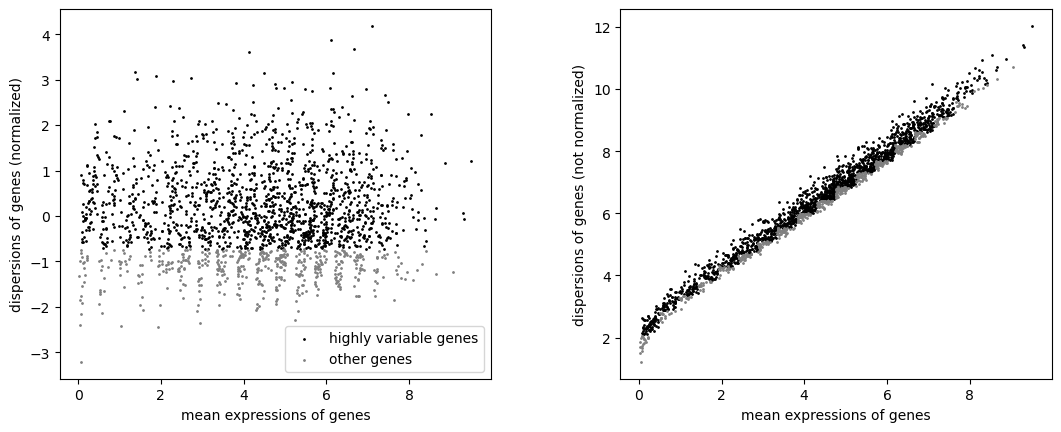

AnnData object with n_obs × n_vars = 2412 × 1500
    obs: 'cluster_id', 'sample_id', 'group_id', 'cell_id', 'sizeFactor', 'cluster_hi', 'cluster_lo'
    var: 'sample_1.Group1.Gene._', 'sample_1.Group1.GeneMean._', 'sample_2.Group1.Gene._', 'sample_2.Group1.GeneMean._', 'sample_3.Group1.Gene._', 'sample_3.Group1.GeneMean._', 'sample_4.Group1.Gene._', 'sample_4.Group1.GeneMean._', 'sample_5.Group1.Gene._', 'sample_5.Group1.GeneMean._', 'sample_6.Group1.Gene._', 'sample_6.Group1.GeneMean._', 'sample_1.Group2.Gene._', 'sample_1.Group2.GeneMean._', 'sample_2.Group2.Gene._', 'sample_2.Group2.GeneMean._', 'sample_3.Group2.Gene._', 'sample_3.Group2.GeneMean._', 'sample_4.Group2.Gene._', 'sample_4.Group2.GeneMean._', 'sample_5.Group2.Gene._', 'sample_5.Group2.GeneMean._', 'sample_6.Group2.Gene._', 'sample_6.Group2.GeneMean._', 'sample_1.Group3.Gene._', 'sample_1.Group3.GeneMean._', 'sample_2.Group3.Gene._', 'sample_2.Group3.GeneMean._', 'sample_3.Group3.Gene._', 'sample_3.Group3.GeneMean._', 's

In [4]:
adata = sc.read_h5ad("../../data/sim/01-pro/t100,s80,b0.h5ad")
adata.X = adata.layers["logcounts"]

sc.pp.highly_variable_genes(adata, n_top_genes=1500)
sc.pl.highly_variable_genes(adata)

adata = adata[:, adata.var["highly_variable"]].copy()
adata.X = adata.layers["counts"] # model input should be raw counts (stated in docs)
adata

## Run Patches in Interpretable Workflow - Condition Only

In [5]:
# Initialize workflow object
workflow = InterpretableWorkflow(adata.copy(), verbose=True, random_seed=42)

# Define the condition classes & batch key to prepare the data
factors = ["group_id"]
workflow.prep_model(factors, batch_key="sample_id", model_type='Patches', model_args={'ld_normalize' : True})

workflow.run_model(max_epochs=100, convergence_threshold=1e-5, convergence_window=10) # Lower the convergence threshold if you need a more accurate model, will increase training time
workflow.save_model("../../data/sim/02-patches/t100,s80,b0-con")

Initialized workflow to run interpretable model.

Condition classes : ['group_id']
Number of attributes per class : [2]

Initialized Patches model.
Model arguments: {'ld_normalize': True, 'reconstruction': 'ZINB_LD', 'batch_correction': True, 'scale_factor': 5.208333333333333e-06, 'num_labels': 2, 'len_attrs': [2]}

Optimizer args parsed successfully. Final arguments: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optim_args': {'lr': 0.001, 'eps': 0.01, 'betas': (0.9, 0.999)}, 'gamma': 1, 'milestones': [10000000000.0]}
Training initialized for a maximum of 100, with convergence eps 1e-05.
Using device: cpu

Epoch : 0 || Train Loss: 232.55654 // 0.72095 || Test Loss: 218.18523 // 0.66492 || Warmup : False
Epoch : 1 || Train Loss: 219.91752 // 0.80447 || Test Loss: 173.6479 // 1.24958 || Warmup : False
Epoch : 2 || Train Loss: 196.57653 // 0.85572 || Test Loss: 125.65854 // 1.00199 || Warmup : False
Epoch : 3 || Train Loss: 160.14338 // 1.13234 || Test Loss: 133.14447 // 1.60704 || Warm

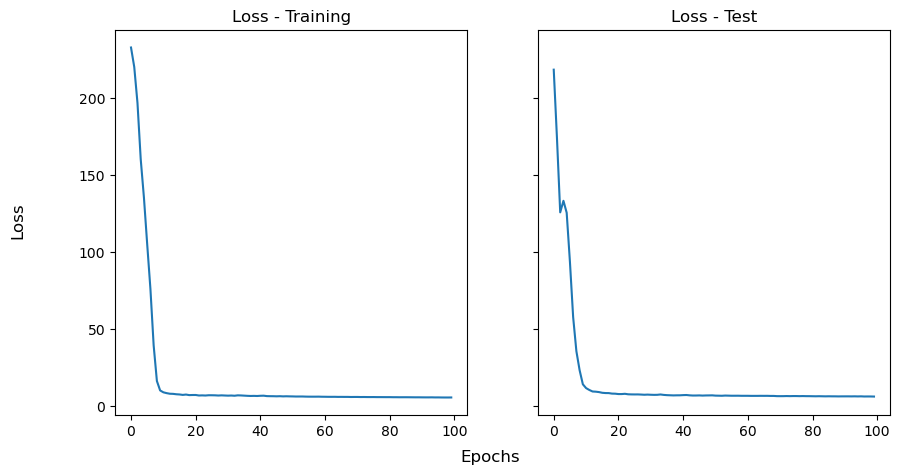

In [6]:
workflow.plot_loss()

In [7]:
workflow.write_embeddings()
workflow.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: PCA, patches_w_latent, patches_z_latent

In [8]:
workflow.evaluate_reconstruction()

Calculating RMSE ...


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Calculating Profile Correlation ...


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Calculating 2-Sliced Wasserstein ...


100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


Calculating Chamfer Discrepancy ...


100%|██████████| 5/5 [00:00<00:00, 66.87it/s]


Results
RMSE : 2.616 +- 0.027
Profile Correlation : 0.962 +- 0.001
2-Sliced Wasserstein : 58.833 +- 5.429
Chamfer Discrepancy : 19037.191 +- 676.72


{'RMSE': [np.float64(2.616), np.float64(0.027)],
 'Profile Correlation': [np.float64(0.962), np.float64(0.001)],
 '2-Sliced Wasserstein': [np.float64(58.833), np.float64(5.429)],
 'Chamfer Discrepancy': [np.float64(19037.191), np.float64(676.72)]}

In [9]:
workflow.get_conditional_loadings()
workflow.get_common_loadings()
workflow.anndata.var

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


,sample_1.Group1.Gene._,sample_1.Group1.GeneMean._,sample_2.Group1.Gene._,sample_2.Group1.GeneMean._,sample_3.Group1.Gene._,sample_3.Group1.GeneMean._,sample_4.Group1.Gene._,sample_4.Group1.GeneMean._,sample_5.Group1.Gene._,sample_5.Group1.GeneMean._,...,cvQuantileNorm,gene_id,bio,highly_variable,means,dispersions,dispersions_norm,Condition1_score_Patches,Condition2_score_Patches,common_score_Patches
gene0001,gene_0001,0.348913,gene_0001,0.339048,gene_0001,0.355008,gene_0001,0.376501,gene_0001,0.318932,...,0.055493,gene0001,0.000427,True,3.131532,5.140881,-0.563131,-0.437328,-0.283276,0.731832
gene0002,gene_0002,0.233752,gene_0002,0.266857,gene_0002,0.090465,gene_0002,0.084239,gene_0002,0.262775,...,0.069999,gene0002,0.025194,True,2.285620,5.125469,2.982031,-0.300750,-0.151496,0.488561
gene0003,gene_0003,1.054020,gene_0003,1.055463,gene_0003,1.050622,gene_0003,1.220659,gene_0003,1.215103,...,0.005916,gene0003,0.012466,True,4.504878,6.532784,-0.335904,-0.043570,-0.008633,0.308892
gene0004,gene_0004,1.333374,gene_0004,1.354434,gene_0004,3.302799,gene_0004,3.356972,gene_0004,1.311693,...,0.024612,gene0004,-0.105671,True,5.283144,7.495395,-0.109482,0.056072,-0.214398,-0.515526
gene0006,gene_0006,0.678394,gene_0006,0.615692,gene_0006,0.653093,gene_0006,0.670220,gene_0006,0.631826,...,0.036017,gene0006,-0.332585,True,3.791115,5.823811,0.401177,-0.294011,0.026050,0.610891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene1995,gene_1995,0.041196,gene_1995,0.041196,gene_1995,0.014945,gene_1995,0.014262,gene_1995,0.038419,...,0.038428,gene1995,0.017049,True,0.755639,3.565730,2.098966,0.043539,-0.003299,0.258160
gene1996,gene_1996,5.450085,gene_1996,5.842951,gene_1996,2.373400,gene_1996,2.211219,gene_1996,5.734554,...,0.028423,gene1996,-0.014956,True,6.399424,8.580151,0.465553,0.221442,0.207428,-0.168647
gene1998,gene_1998,3.358019,gene_1998,2.716563,gene_1998,3.271921,gene_1998,3.314637,gene_1998,3.261122,...,0.076022,gene1998,-0.395457,True,5.986918,7.898090,0.002362,0.019130,0.332916,0.336187
gene1999,gene_1999,1.414115,gene_1999,1.194894,gene_1999,1.214520,gene_1999,1.187953,gene_1999,1.102327,...,0.033697,gene1999,-0.107000,True,4.650305,6.790688,0.597904,0.304882,0.094972,0.201743


In [10]:
for gene in (workflow.anndata.var["Condition2_score_Patches"]).sort_values(ascending=False)[:200].index:
    print(gene, workflow.anndata.var.loc[gene, ["Condition2_score_Patches"]].values[0])

gene1455 0.7442719843241556
gene0026 0.6890011807403138
gene0630 0.6606970515484911
gene1953 0.6142805281518753
gene0885 0.5864923241222585
gene0690 0.5851615807617079
gene0199 0.5843056047588205
gene0937 0.5691485142105306
gene0538 0.5646423683389348
gene0374 0.5439972989015052
gene0440 0.5385236515796413
gene0101 0.5231111948205567
gene0686 0.5175269941070628
gene1062 0.5094922488942176
gene1972 0.5094595728963397
gene1347 0.50617438984823
gene1115 0.5013131428564743
gene0262 0.49419873298156836
gene0312 0.49418777736444974
gene0526 0.490924378528829
gene0021 0.48417799597199385
gene0947 0.4811761304216415
gene1143 0.4741140489694017
gene0124 0.4715194572803316
gene0513 0.47073947083536155
gene0404 0.4698090918285164
gene0476 0.4647833070113586
gene0081 0.46149230299450084
gene0658 0.457336751731663
gene0417 0.45588745143073284
gene1203 0.45094829841219286
gene1631 0.4490038751236332
gene0190 0.44595487030274145
gene1725 0.4456479775131267
gene1057 0.43611794444884533
gene1437 0.4357

In [11]:
workflow.anndata.var.loc[:, ["Condition1_score_Patches", "Condition2_score_Patches", "common_score_Patches"]].to_csv(
    "../../data/sim/02-patches/t100,s80,b0-con_loadings.csv"
)

In [12]:
workflow.anndata

AnnData object with n_obs × n_vars = 2412 × 1500
    obs: 'cluster_id', 'sample_id', 'group_id', 'cell_id', 'sizeFactor', 'cluster_hi', 'cluster_lo', 'factorized'
    var: 'sample_1.Group1.Gene._', 'sample_1.Group1.GeneMean._', 'sample_2.Group1.Gene._', 'sample_2.Group1.GeneMean._', 'sample_3.Group1.Gene._', 'sample_3.Group1.GeneMean._', 'sample_4.Group1.Gene._', 'sample_4.Group1.GeneMean._', 'sample_5.Group1.Gene._', 'sample_5.Group1.GeneMean._', 'sample_6.Group1.Gene._', 'sample_6.Group1.GeneMean._', 'sample_1.Group2.Gene._', 'sample_1.Group2.GeneMean._', 'sample_2.Group2.Gene._', 'sample_2.Group2.GeneMean._', 'sample_3.Group2.Gene._', 'sample_3.Group2.GeneMean._', 'sample_4.Group2.Gene._', 'sample_4.Group2.GeneMean._', 'sample_5.Group2.Gene._', 'sample_5.Group2.GeneMean._', 'sample_6.Group2.Gene._', 'sample_6.Group2.GeneMean._', 'sample_1.Group3.Gene._', 'sample_1.Group3.GeneMean._', 'sample_2.Group3.Gene._', 'sample_2.Group3.GeneMean._', 'sample_3.Group3.Gene._', 'sample_3.Group3.G

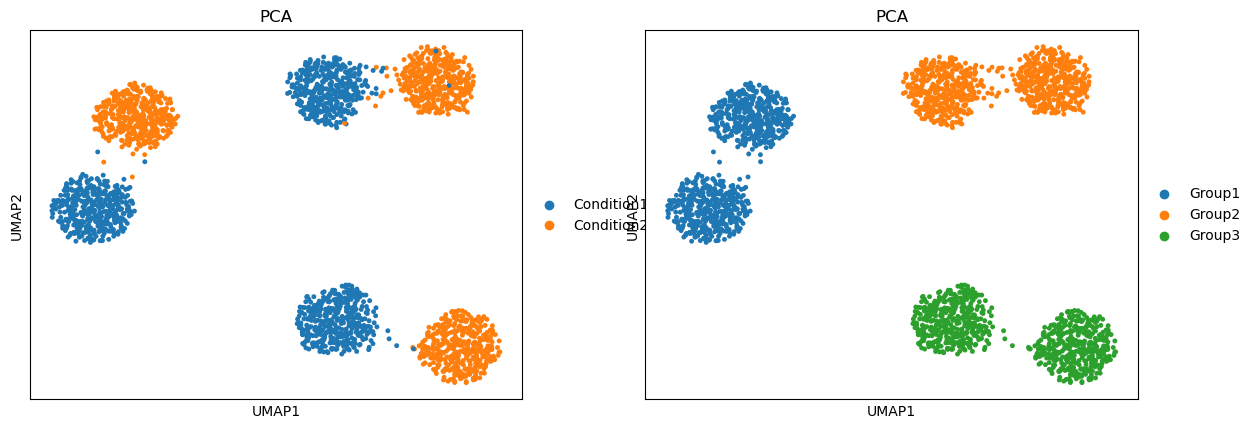

In [13]:
sc.pp.neighbors(workflow.anndata, use_rep="PCA")
sc.tl.umap(workflow.anndata)
sc.pl.umap(workflow.anndata, color=["group_id", "cluster_id"], title=["PCA", "PCA"])

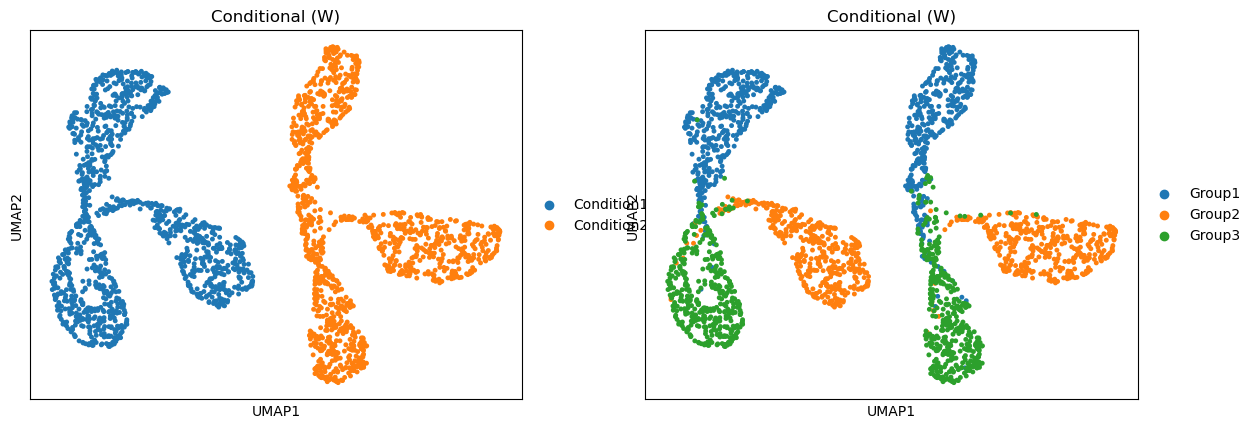

In [14]:
sc.pp.neighbors(workflow.anndata, use_rep="patches_w_latent")
sc.tl.umap(workflow.anndata)
sc.pl.umap(workflow.anndata, color=["group_id", "cluster_id"], title=["Conditional (W)", "Conditional (W)"])

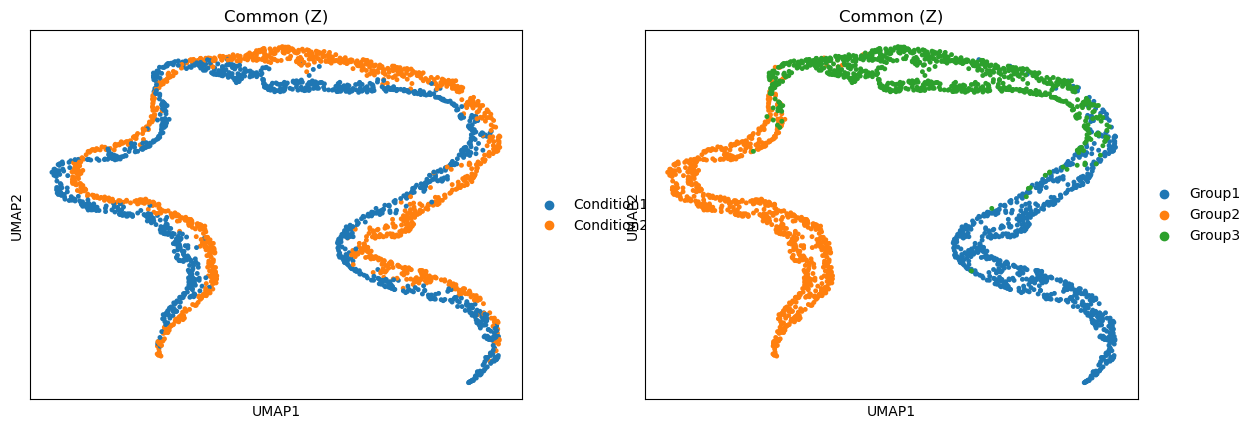

In [15]:
sc.pp.neighbors(workflow.anndata, use_rep="patches_z_latent")
sc.tl.umap(workflow.anndata)
sc.pl.umap(workflow.anndata, color=["group_id", "cluster_id"], title=["Common (Z)", "Common (Z)"])

In [40]:
df_patches = create_umap_df(workflow, "Patches")
df_patches

/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,base_1,base_2,z_umap_1,z_umap_2,w_umap_1,w_umap_2,z_pc_1,z_pc_2,w_pc_1,w_pc_2,group_id,cluster_id,sample_id
cell0001,-1.882721,11.294888,11.488538,3.937386,11.483005,4.858228,0.163882,-0.232689,1.400479,-0.016053,Condition2,Group1,sample_1
cell0002,-1.832941,14.198952,11.328350,-2.544496,9.139380,-0.991354,-1.527207,-0.378699,1.283218,-0.291440,Condition2,Group1,sample_1
cell0003,-0.372458,13.683484,11.635402,5.775770,11.157330,5.421101,0.576616,-0.200026,1.265489,0.012950,Condition2,Group1,sample_1
cell0004,-0.539119,9.510109,10.963658,1.074300,10.017889,1.405284,-0.628795,-0.362272,1.319410,-0.151384,Condition2,Group1,sample_1
cell0005,1.654866,12.469720,11.359186,-0.243821,8.705492,0.113981,-0.931774,-0.341228,1.194938,-0.240980,Condition2,Group1,sample_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell2408,2.096856,15.830647,11.746086,6.304581,-3.135798,9.334000,0.720569,-0.276918,-1.554199,0.350075,Condition1,Group3,sample_6
cell2409,-0.404600,8.929997,3.693733,12.677205,-5.802664,7.331552,1.901348,0.072246,-1.506906,0.623975,Condition1,Group3,sample_6
cell2410,3.705880,15.322731,2.945853,12.839385,-6.435579,6.113277,1.770550,0.062872,-1.386998,0.552523,Condition1,Group3,sample_6
cell2411,-0.686988,9.033719,5.693338,12.366553,-1.748006,8.185308,1.993322,-0.011416,-1.389832,0.604726,Condition1,Group3,sample_6


In [43]:
df_base = create_umap_df(workflow, "Base")
df_base

/Users/michel/miniconda3/envs/type-state/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,base_umap_1,base_umap_2,base_pc_1,base_pc_2,group_id,cluster_id,sample_id
cell0001,17.250772,17.701426,-5.032496,-3.621988,Condition2,Group1,sample_1
cell0002,17.710779,18.129248,-5.169569,-7.503455,Condition2,Group1,sample_1
cell0003,17.736948,17.757309,-5.584240,-2.394084,Condition2,Group1,sample_1
cell0004,17.237457,17.748421,-4.806931,-5.255695,Condition2,Group1,sample_1
cell0005,17.481018,18.047880,-2.606133,-4.326013,Condition2,Group1,sample_1
...,...,...,...,...,...,...,...
cell2408,14.345898,15.556160,5.094957,-3.186167,Condition1,Group3,sample_6
cell2409,14.713074,15.135434,4.370385,1.113111,Condition1,Group3,sample_6
cell2410,15.664406,15.832342,3.812494,1.759742,Condition1,Group3,sample_6
cell2411,14.402739,15.292412,2.788968,0.325320,Condition1,Group3,sample_6


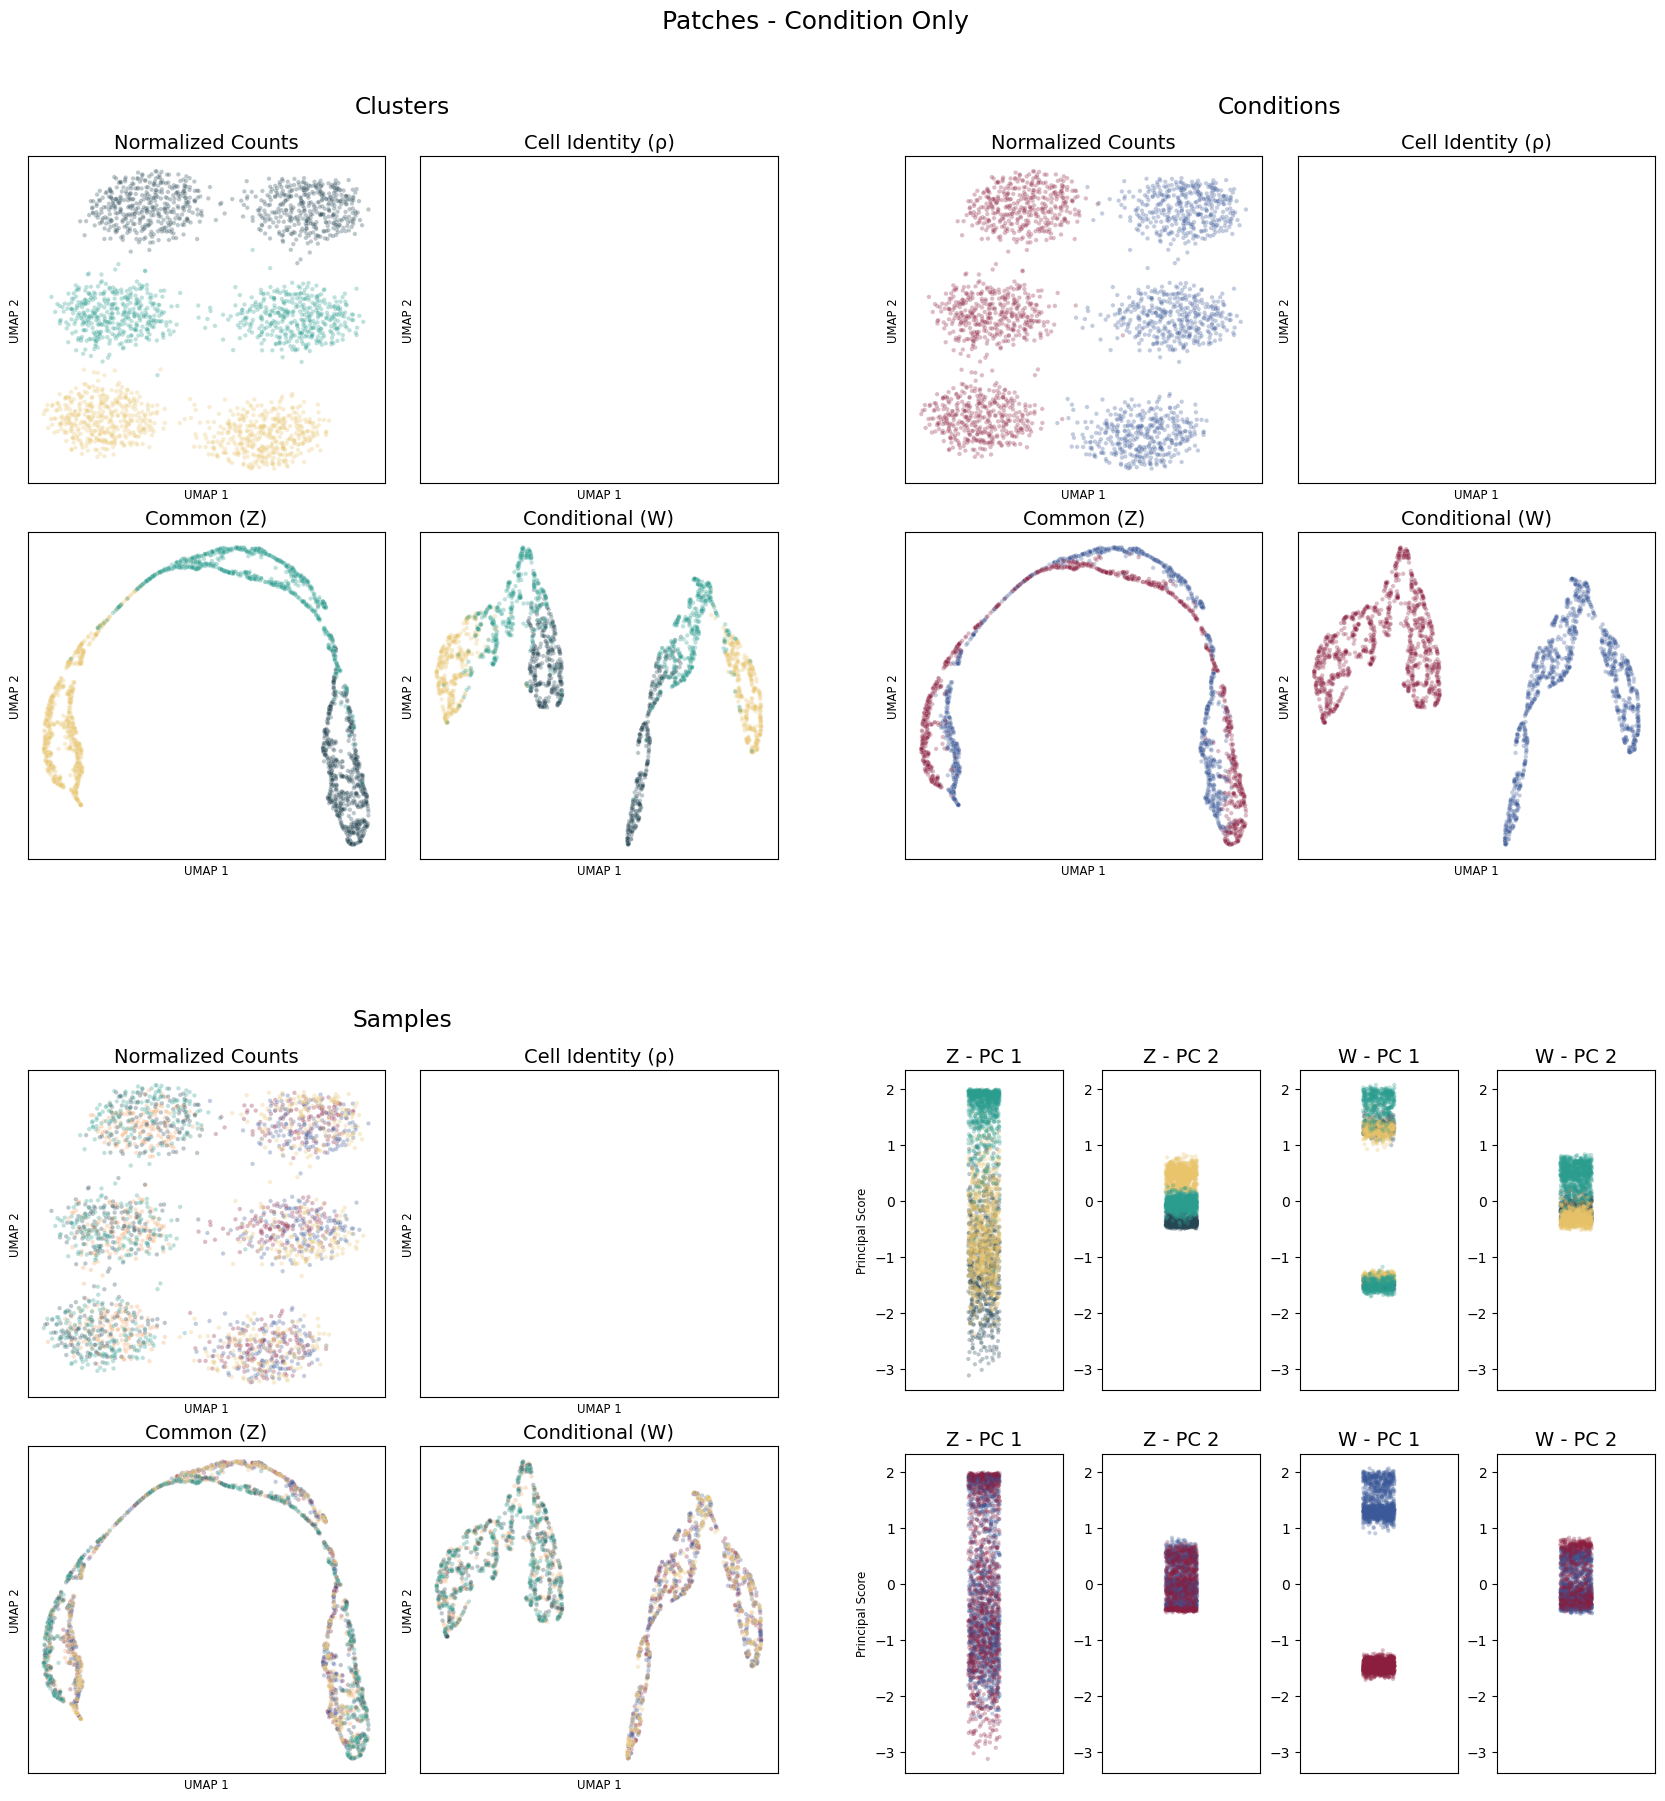

In [72]:
# Figure skeleton (adapted from Patches tutorial docs)


## color palettes
klee_palette = [
    "#8B1E3F",  # Deep Burgundy
    "#3B5998",  # Rich Blue
    "#F4A261",  # Warm Orange
    "#264653",  # Deep Teal
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#D3D9E3",  # Soft Pastel Blue
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]

klee_palette_masch = [
    "#3B5998",  # Rich Blue
    "#6A994E",  # Fresh Olive Green
    "#F4A261",  # Warm Orange
    "#E9C46A",  # Soft Yellow
    "#2A9D8F",  # Muted Green
    "#E76F51",  # Burnt Sienna
    "#FFC8A2",  # Soft Peach
    "#A8DADC",  # Pale Turquoise
    "#BC4749",  # Warm Cranberry Red
]


## plot parameters
fontsize=14
alpha=0.3
s=10
s_pca=3


## create a figure with a 2x2 grid of subplots
fig = plt.figure(figsize=(21, 21))

## define a GridSpec with a 2x2 layout
gs = gridspec.GridSpec(2, 2, wspace=0.17, hspace = 0.3, figure=fig)

## create subplots for the 2x2 grid
ax = [fig.add_subplot(gs[i//2, i%2]) for i in range(4)]

for subax in ax:
    subax.axis('off')

## define a new GridSpec for axis to split vertically
gs_inner_topleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], wspace=0.1, hspace=0.15)
gs_inner_topright = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], wspace=0.1, hspace=0.15)
gs_inner_botleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1, 0], wspace=0.1, hspace=0.15)
gs_inner_botright = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1, 1], wspace=0.25)

## create subplots for the inner grid
ax_inner_topleft = [fig.add_subplot(gs_inner_topleft[i//2, i%2]) for i in range(4)]
ax_inner_topright = [fig.add_subplot(gs_inner_topright[i//2, i%2]) for i in range(4)]
ax_inner_botleft = [fig.add_subplot(gs_inner_botleft[i//2, i%2]) for i in range(4)]

## specific for botright
ax_inner_botright = [fig.add_subplot(gs_inner_botright[0,0])]
ax_inner_botright = ax_inner_botright \
+ [
    fig.add_subplot(gs_inner_botright[0,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[0,3],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,0],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,1],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,2],sharey=ax_inner_botright[0]),
    fig.add_subplot(gs_inner_botright[1,3],sharey=ax_inner_botright[0]),
]


## UMAP plots

### counts
clu = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topright[0], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha)
con = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_topleft[0], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha)
sam = sns.scatterplot(df_base, x='base_umap_1', y='base_umap_2', ax=ax_inner_botleft[0], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha)

### Zs
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topright[2], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_topleft[2], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='z_umap_1', y='z_umap_2', ax=ax_inner_botleft[2], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)

### Ws
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topright[3], hue = 'group_id', palette=sns.color_palette(klee_palette[0:2]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_topleft[3], hue = 'cluster_id', palette=sns.color_palette(klee_palette[3:6]), s=s, alpha=alpha, legend=False)
sns.scatterplot(df_patches, x='w_umap_1', y='w_umap_2', ax=ax_inner_botleft[3], hue = 'sample_id', palette=sns.color_palette(klee_palette[0:6]), s=s, alpha=alpha, legend=False)


## PCA plots

### cluster
sns.stripplot(df_patches, y = "z_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[0], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[0].axvline(zorder=2, color='black', linestyle = 'dashed')
    
sns.stripplot(df_patches, y = "z_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[1], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[1].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[2], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[2].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='cluster_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[3], legend=False, palette=sns.color_palette(klee_palette[3:6]))
#ax_inner_botright[3].axvline(zorder=2, color='black', linestyle = 'dashed')


### condition
sns.stripplot(df_patches, y = "z_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[4], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[4].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "z_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[5], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[5].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_1", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[6], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[6].axvline(zorder=2, color='black', linestyle = 'dashed')

sns.stripplot(df_patches, y = "w_pc_2", hue='group_id', zorder=1, alpha=alpha, s=s_pca, ax=ax_inner_botright[7], legend=False, palette=sns.color_palette(klee_palette[0:2]))
#ax_inner_botright[7].axvline(zorder=2, color='black', linestyle = 'dashed')


## formatting

for subax in ax_inner_topright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_topleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botleft:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_yticklabels([])
    subax.set_yticks([])
    subax.set_xlabel('UMAP 1', fontsize=fontsize*0.6)
    subax.set_ylabel('UMAP 2', fontsize=fontsize*0.6)
    try:
        force_aspect(subax)
    except:
        pass

for subax in ax_inner_botright:
    subax.set_xticklabels([])
    subax.set_xticks([])
    subax.set_xlabel('')
    subax.set_ylabel('')

ax_inner_botright[0].set_ylabel('Principal Score', fontsize=fontsize*0.6)
ax_inner_botright[4].set_ylabel('Principal Score', fontsize=fontsize*0.6)

clu_h, clu_l = clu.get_legend_handles_labels() 
con_h, con_l = con.get_legend_handles_labels()
sam_h, sam_l = sam.get_legend_handles_labels()

clu.legend([], frameon=False); con.legend([], frameon=False); sam.legend([], frameon=False)

ax_inner_topleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_topright[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_topright[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_topright[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_topright[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botleft[0].set_title('Normalized Counts', fontsize=fontsize)
ax_inner_botleft[1].set_title('Cell Identity (ρ)', fontsize=fontsize)
ax_inner_botleft[2].set_title('Common (Z)', fontsize=fontsize)
ax_inner_botleft[3].set_title('Conditional (W)', fontsize=fontsize)

ax_inner_botright[0].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[1].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[2].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[3].set_title('W - PC 2', fontsize=fontsize)
ax_inner_botright[4].set_title('Z - PC 1', fontsize=fontsize)
ax_inner_botright[5].set_title('Z - PC 2', fontsize=fontsize)
ax_inner_botright[6].set_title('W - PC 1', fontsize=fontsize)
ax_inner_botright[7].set_title('W - PC 2', fontsize=fontsize)


## set subplot titles
titles = ['Clusters', 'Conditions', 'Samples', '']

for a, t in zip(ax, titles):
    a.set_title(t, y=1.05, fontsize=fontsize*1.2)


## save and show figure
fig.suptitle("Patches - Condition Only", fontsize=18, y=0.95)
plt.savefig("../../data/sim/02-patches/t100,s80,b0-con.png", dpi=300, bbox_inches='tight')
plt.show()

## Run Patches in Interpretable Workflow - Condition + Cluster

In [16]:
# Initialize workflow object
workflow2 = InterpretableWorkflow(adata.copy(), verbose=True, random_seed=42)

# Define the condition classes & batch key to prepare the data
factors = ["group_id", "cluster_id"]
workflow2.prep_model(factors, batch_key="sample_id", model_type='Patches', model_args={'ld_normalize' : True})

workflow2.run_model(max_epochs=100, convergence_threshold=1e-5, convergence_window=10) # Lower the convergence threshold if you need a more accurate model, will increase training time
workflow2.save_model("../../data/sim/02-patches/t100,s80,b0-con-clu")

Initialized workflow to run interpretable model.

Condition classes : ['group_id', 'cluster_id']
Number of attributes per class : [2, 3]

Initialized Patches model.
Model arguments: {'ld_normalize': True, 'reconstruction': 'ZINB_LD', 'batch_correction': True, 'scale_factor': 5.208333333333333e-06, 'num_labels': 5, 'len_attrs': [2, 3]}

Optimizer args parsed successfully. Final arguments: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optim_args': {'lr': 0.001, 'eps': 0.01, 'betas': (0.9, 0.999)}, 'gamma': 1, 'milestones': [10000000000.0]}
Training initialized for a maximum of 100, with convergence eps 1e-05.
Using device: cpu

Epoch : 0 || Train Loss: 232.92158 // 1.87079 || Test Loss: 224.58322 // 1.81943 || Warmup : False
Epoch : 1 || Train Loss: 220.29461 // 1.82054 || Test Loss: 197.49765 // 1.90503 || Warmup : False
Epoch : 2 || Train Loss: 198.11095 // 1.96122 || Test Loss: 147.29601 // 2.13952 || Warmup : False
Epoch : 3 || Train Loss: 165.4762 // 1.96678 || Test Loss: 118.3887

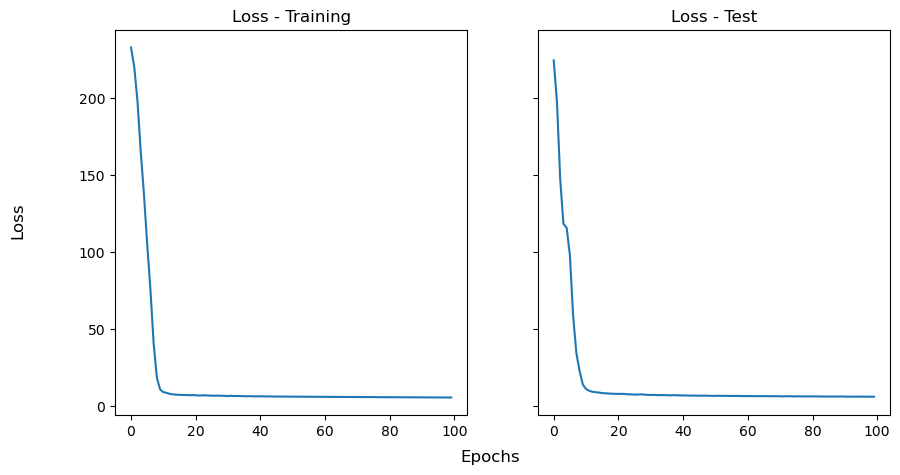

In [17]:
workflow2.plot_loss()

In [18]:
workflow2.write_embeddings()
workflow2.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: PCA, patches_w_latent, patches_z_latent

In [19]:
workflow2.evaluate_reconstruction()

Calculating RMSE ...


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Calculating Profile Correlation ...


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Calculating 2-Sliced Wasserstein ...


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Calculating Chamfer Discrepancy ...


100%|██████████| 5/5 [00:00<00:00, 184.93it/s]

Results
RMSE : 6.248 +- 0.06
Profile Correlation : 0.75 +- 0.005
2-Sliced Wasserstein : 56.954 +- 0.832
Chamfer Discrepancy : 15979.46 +- 189.872


{'RMSE': [np.float64(6.248), np.float64(0.06)],
 'Profile Correlation': [np.float64(0.75), np.float64(0.005)],
 '2-Sliced Wasserstein': [np.float64(56.954), np.float64(0.832)],
 'Chamfer Discrepancy': [np.float64(15979.46), np.float64(189.872)]}

In [20]:
workflow2.get_conditional_loadings()
workflow2.get_common_loadings()
workflow2.anndata.var

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


,sample_1.Group1.Gene._,sample_1.Group1.GeneMean._,sample_2.Group1.Gene._,sample_2.Group1.GeneMean._,sample_3.Group1.Gene._,sample_3.Group1.GeneMean._,sample_4.Group1.Gene._,sample_4.Group1.GeneMean._,sample_5.Group1.Gene._,sample_5.Group1.GeneMean._,...,highly_variable,means,dispersions,dispersions_norm,Condition1_score_Patches,Condition2_score_Patches,Group1_score_Patches,Group2_score_Patches,Group3_score_Patches,common_score_Patches
gene0001,gene_0001,0.348913,gene_0001,0.339048,gene_0001,0.355008,gene_0001,0.376501,gene_0001,0.318932,...,True,3.131532,5.140881,-0.563131,-0.057176,-0.131690,0.135256,-0.103804,-0.114140,0.142928
gene0002,gene_0002,0.233752,gene_0002,0.266857,gene_0002,0.090465,gene_0002,0.084239,gene_0002,0.262775,...,True,2.285620,5.125469,2.982031,-0.010742,-0.117186,0.411316,-0.236712,-0.165547,-0.048629
gene0003,gene_0003,1.054020,gene_0003,1.055463,gene_0003,1.050622,gene_0003,1.220659,gene_0003,1.215103,...,True,4.504878,6.532784,-0.335904,-0.282298,-0.011665,-0.230761,0.141152,0.284129,0.347348
gene0004,gene_0004,1.333374,gene_0004,1.354434,gene_0004,3.302799,gene_0004,3.356972,gene_0004,1.311693,...,True,5.283144,7.495395,-0.109482,-0.139416,-0.071922,0.032616,-0.023970,-0.285812,0.102222
gene0006,gene_0006,0.678394,gene_0006,0.615692,gene_0006,0.653093,gene_0006,0.670220,gene_0006,0.631826,...,True,3.791115,5.823811,0.401177,-0.004614,-0.019083,0.293137,-0.045536,0.221748,-0.408208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene1995,gene_1995,0.041196,gene_1995,0.041196,gene_1995,0.014945,gene_1995,0.014262,gene_1995,0.038419,...,True,0.755639,3.565730,2.098966,0.298571,-0.340035,-0.278122,-0.395262,0.128364,-0.023670
gene1996,gene_1996,5.450085,gene_1996,5.842951,gene_1996,2.373400,gene_1996,2.211219,gene_1996,5.734554,...,True,6.399424,8.580151,0.465553,-0.180657,0.390692,0.134430,0.079714,-0.114036,0.573838
gene1998,gene_1998,3.358019,gene_1998,2.716563,gene_1998,3.271921,gene_1998,3.314637,gene_1998,3.261122,...,True,5.986918,7.898090,0.002362,-0.092606,0.049372,0.039837,0.112745,0.048958,0.007860
gene1999,gene_1999,1.414115,gene_1999,1.194894,gene_1999,1.214520,gene_1999,1.187953,gene_1999,1.102327,...,True,4.650305,6.790688,0.597904,0.332444,-0.037316,-0.104802,-0.016917,-0.047214,-0.234991


In [21]:
for gene in (workflow2.anndata.var["Condition2_score_Patches"]).sort_values(ascending=False)[:200].index:
    print(gene, workflow2.anndata.var.loc[gene, ["Condition2_score_Patches"]].values[0])

gene0199 0.6981504528424753
gene0417 0.6908329742952259
gene0440 0.6710756444148518
gene0374 0.5830942282755276
gene1455 0.5614587469088491
gene0867 0.5426212385860971
gene0312 0.5287661418039381
gene0885 0.4817541054499678
gene0630 0.4401126880318409
gene1017 0.4361903152560551
gene0190 0.4335040966019983
gene0561 0.4220582208895092
gene0658 0.4200839272322662
gene1214 0.4129025732261007
gene1057 0.4114940126924133
gene0538 0.4106216714752182
gene1035 0.3981661129945566
gene0406 0.39305611760297654
gene0584 0.3912094501344364
gene1996 0.39069210240259983
gene0686 0.3896010458543651
gene0725 0.38865857830634487
gene1347 0.3725393631752372
gene0262 0.371148922911054
gene0101 0.368917492080641
gene0073 0.36643374992171907
gene0129 0.36310757130991506
gene0989 0.3629592753363028
gene1878 0.3602435903807104
gene0882 0.3519090161205064
gene1128 0.34963692872342533
gene1508 0.34807215808508685
gene0188 0.34798054023530944
gene1317 0.34633516447950025
gene1712 0.3460153042750931
gene0553 0.34

In [22]:
workflow2.anndata.var.loc[:, [
    "Condition1_score_Patches", 
    "Condition2_score_Patches", 
    "common_score_Patches", 
    "Group1_score_Patches", 
    "Group2_score_Patches", 
    "Group3_score_Patches"
    ]].to_csv(
    "../../data/sim/02-patches/t100,s80,b0-con-clu_loadings.csv"
)

In [23]:
workflow2.anndata

AnnData object with n_obs × n_vars = 2412 × 1500
    obs: 'cluster_id', 'sample_id', 'group_id', 'cell_id', 'sizeFactor', 'cluster_hi', 'cluster_lo', 'factorized'
    var: 'sample_1.Group1.Gene._', 'sample_1.Group1.GeneMean._', 'sample_2.Group1.Gene._', 'sample_2.Group1.GeneMean._', 'sample_3.Group1.Gene._', 'sample_3.Group1.GeneMean._', 'sample_4.Group1.Gene._', 'sample_4.Group1.GeneMean._', 'sample_5.Group1.Gene._', 'sample_5.Group1.GeneMean._', 'sample_6.Group1.Gene._', 'sample_6.Group1.GeneMean._', 'sample_1.Group2.Gene._', 'sample_1.Group2.GeneMean._', 'sample_2.Group2.Gene._', 'sample_2.Group2.GeneMean._', 'sample_3.Group2.Gene._', 'sample_3.Group2.GeneMean._', 'sample_4.Group2.Gene._', 'sample_4.Group2.GeneMean._', 'sample_5.Group2.Gene._', 'sample_5.Group2.GeneMean._', 'sample_6.Group2.Gene._', 'sample_6.Group2.GeneMean._', 'sample_1.Group3.Gene._', 'sample_1.Group3.GeneMean._', 'sample_2.Group3.Gene._', 'sample_2.Group3.GeneMean._', 'sample_3.Group3.Gene._', 'sample_3.Group3.G

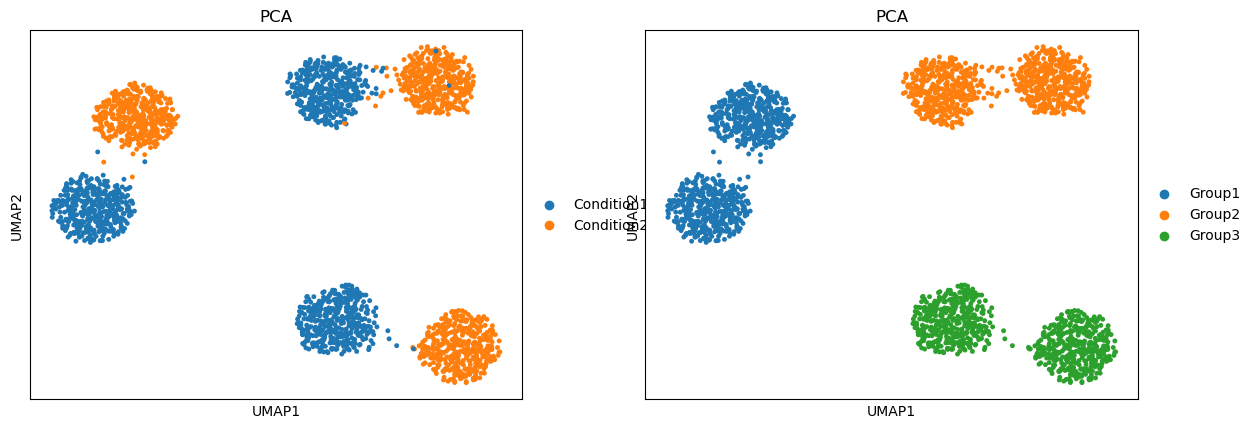

In [24]:
sc.pp.neighbors(workflow2.anndata, use_rep="PCA")
sc.tl.umap(workflow2.anndata)
sc.pl.umap(workflow2.anndata, color=["group_id", "cluster_id"], title=["PCA", "PCA"])

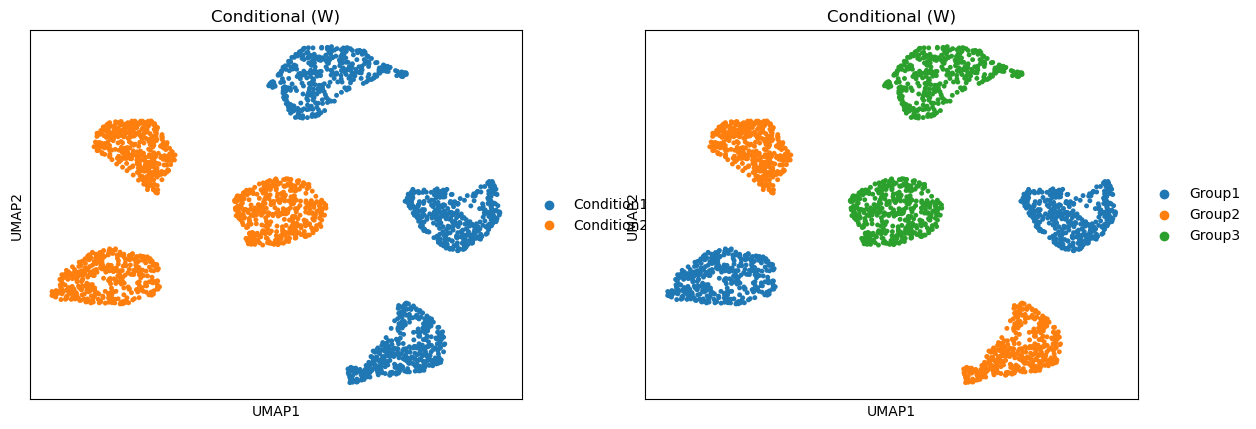

In [25]:
sc.pp.neighbors(workflow2.anndata, use_rep="patches_w_latent")
sc.tl.umap(workflow2.anndata)
sc.pl.umap(workflow2.anndata, color=["group_id", "cluster_id"], title=["Conditional (W)", "Conditional (W)"])

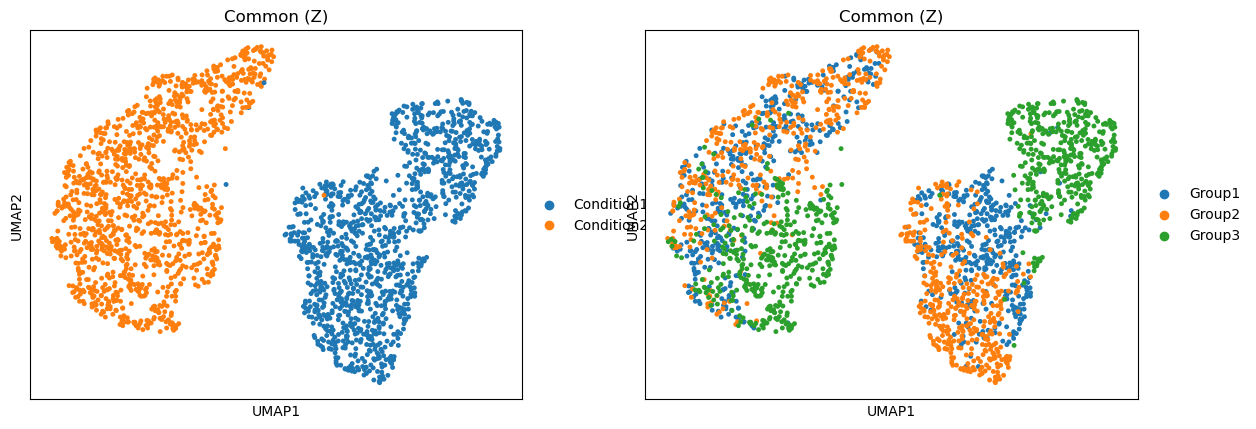

In [26]:
sc.pp.neighbors(workflow2.anndata, use_rep="patches_z_latent")
sc.tl.umap(workflow2.anndata)
sc.pl.umap(workflow2.anndata, color=["group_id", "cluster_id"], title=["Common (Z)", "Common (Z)"])